## Gradient Descent


In [34]:

from typing import Callable

def difference_quotient(f: Callable[[float], float], x: float, h: float=0.01) -> float:
    return (f(x+h) - f(x))/h

def square(x: float) -> float:
    return x*x

def derivative_x_squared(x:float) -> float:
    return 2*x

Imagine we couldn't find the exact derivative, we can use the difference quotient approximation

the true derivative value = 14, and the approx = 14.099999999999966


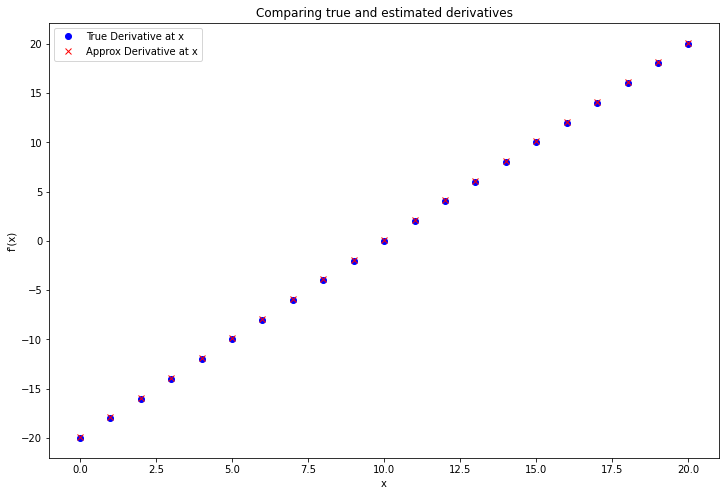

In [87]:
import matplotlib.pyplot as plt

test_lambda = lambda x: x*x

the_derivative_approx = difference_quotient(test_lambda,7, 0.001) #the estimated value using the difference quotient rule
the_derivative = derivative_x_squared(7) #the derived derivative.
 
print(f'the true derivative value = {the_derivative}, and the approx = {the_derivative_approx}')

h = 0.1
xs = range(-10,11)

derivative_values = [derivative_x_sqaured(x) for x in xs]
derivative_values_approx = [difference_quotient(square,x,h) for x in xs]

figure, ax = plt.subplots(figsize=(12,8))

ax.plot(derivative_values, label="True Derivative at x", color="blue", marker="o",linestyle="")
ax.plot(derivative_values_approx, label="Approx Derivative at x", color="red", marker="x", linestyle="")

ax.set_xlabel("x")
ax.set_ylabel("f'(x)")
ax.set_title("Comparing true and estimated derivatives")
ax.legend()
plt.show()

The graph above shows that there is virutally no difference between the approximation and the true value, for small $h$

In [269]:
from helpers import sum_of_vector_squares, Vector, scalar_mult, add, vector_distance

def partial_difference_quotiant(f: Callable[[Vector], float], v: Vector, i: int, h:float) -> float:
    """Returns the i-th partial difference quotient of f at v """
    w = [v_j + (h if j==i else 0) for j, v_j in enumerate(v)]
    return (f(w)-f(v))/h

def f(v: Vector) -> float:
    return sum_of_vector_squares(v)
    
partial_difference_quotiant(f, [5,4],0,0.001) #in this example our test f(V) is just the sum(V^2)

def estimate_gradient(f: Callable[[Vector],float], v:Vector, h:float=0.0001): 
    return [partial_difference_quotiant(f, v, i, h) for i in range(len(v))]

estimate_gradient(f, [4,5],0.001)

import random

def gradient_step(v: Vector, gradient: Vector,learning_rate: float) -> Vector:
    """Moves step-size in the gradient direction from 'v' """
    assert len(v) == len(gradient)
    step = scalar_mult(learning_rate,gradient) #this is the learning*gradient
    return add(v,step) #move in the direction of the step.

def sum_of_squares_gradient(v: Vector) -> Vector:
    return [2*v_i for v_i in v]

#pick a random starting point
v = [random.uniform(-10,10) for i in range(3)]

for epoch in range(1000):
    grad = sum_of_squares_gradient(v)
    v = gradient_step(v, grad, -0.01)
    #print(epoch, v)

assert vector_distance(v,[0,0,0]) < 0.01

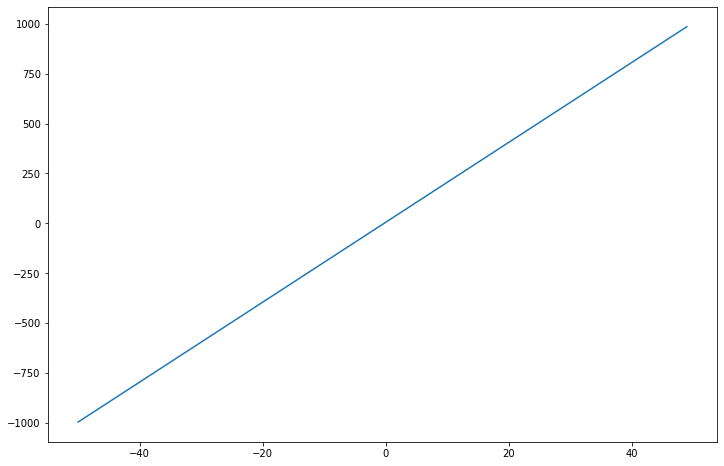

In [271]:
inputs = [(x, 20*x+5) for x in range(-50,50)] #we create the data

import matplotlib.pyplot as plt

#print(inputs)
#print(f"inputs = {zip(*inputs)}")

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(*zip(*inputs))
plt.show()


Imagine we wanted to compute the linear relationship between x,y assuming we didn't know it. We'll use gradient descrent to fing the slope and the intercept that minimises the average squared error. 


In [229]:
def linear_gradient(x: float, y:float, theta: Vector) -> Vector: 
    slope, intercept = theta #the paremeters that we try 
    
    predicted = slope*x + intercept #predicted value based on parameter theta.
    
    error = (predicted-y)
    squared_error = error ** 2 
    grad = [2*error *x , 2 *error] #tells us the direction in which we should nudge the parameter to minimise the loss.
    return grad

linear_gradient(-50, -995, [20,4]) #try a parameter and it will return the gradient that tells us how to modify the parameters and to try again.


[100, -2]

Now say we want to run this for a whole dataset. We instead consider the average (mean) squared error.

$$ 
MSE = \frac{1}{n}\sum_{i=1}^{n} (\hat{y} -y)^2
$$

and the gradient of MSE is just the average of the individual gradients.

So the process over Gradient Descent is as follows:
1. Start with a random value for $\theta$
2. Compute the mean of the gradients.
3. Adjust $\theta (=\theta_{old} + \eta * grad_{\theta})$, where $\eta$ is the learning rate.
4. Repeat

In [299]:
from helpers import vector_mean, subtract

theta = [random.uniform(-1,1), random.uniform(-1,1)]

learning_rate = 0.001

for epoch in range(5000):
    gradients = [linear_gradient(x,y,theta) for x,y in inputs]
    grad_mean = vector_mean(gradients)
    #create the new theta
    step = scalar_mult(learning_rate,grad_mean)
    theta = subtract(theta,step)
   # print(epoch, theta)

slope, intercept = theta
print(f"The model approximated parameters are: slope = {slope}, intercept = {intercept}")

The model approximated parameters are: slope = 19.99999987823148, intercept = 4.999797255346059


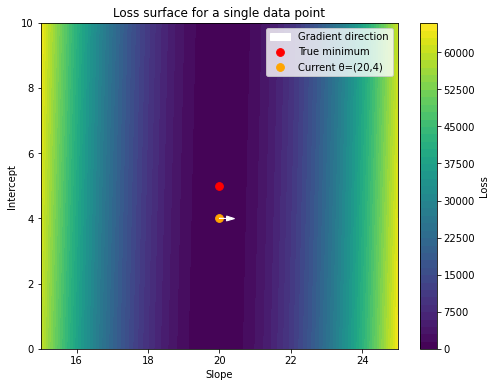

In [239]:
import numpy as np
import matplotlib.pyplot as plt

# Data point
x, y = -50, -995

# Define grid of slope & intercept values
slopes = np.linspace(15, 25, 100)
intercepts = np.linspace(0, 10, 100)
S, I = np.meshgrid(slopes, intercepts)

# Compute loss surface
L = (S * x + I - y) ** 2

# Plot contour
plt.figure(figsize=(8,6))
cs = plt.contourf(S, I, L, levels=50, cmap="viridis")
plt.colorbar(label="Loss")

# Mark the true minimum (20,5)
plt.scatter(20, 5, color='red', s=60, label='True minimum')

# Mark our current guess (20,4)
plt.scatter(20, 4, color='orange', s=60, label='Current θ=(20,4)')

# Draw gradient arrow [100, -2] scaled down for visibility
plt.arrow(20, 4, 0.2, -0.004, color='white', head_width=0.15, label='Gradient direction')

plt.xlabel("Slope")
plt.ylabel("Intercept")
plt.title("Loss surface for a single data point")
plt.legend()
plt.show()


## Minibatch Gradient Descent

For speed improvements we can compute the gradient on a subset of the data (called a batch).

In [324]:
from typing import TypeVar, List, Iterator

T = TypeVar('T') #this alls us to type generic functions

def minibatches(dataset: List[T], batch_size: int, shuffle: bool=True) -> Iterator[List[T]]:
    """ Generates the a mini-batch equal to 'batch_size' from the data."""
    batch_starts = [start for start in range(0, len(dataset),batch_size)]
  

    if shuffle: random.shuffle(batch_starts) #shuffle the batch_starts, so that the orders isn't just scending, this allows us to grab data
        #from different parts of the data set across each run.

    #print(f"Starting batch_starts ] {batch_starts}")
    for start in batch_starts:
        end = start + batch_size
        yield dataset[start:end]

minibatches(inputs,10)

theta = [random.uniform(-1,1),random.uniform(-1,1)]

for epoch in range(1000):
    for batch in minibatches(inputs,batch_size=20, shuffle=True):  
        gradients = [linear_gradient(x,y,theta) for x,y in batch] #just find the grad on the minibatch of data. not everything.
        grad_mean = vector_mean(gradients)
        #create the new theta
        step = scalar_mult(learning_rate,grad_mean)
        theta = subtract(theta,step)

slope, intercept = theta
print(f"The model approximated parameters are: slope = {slope}, intercept = {intercept}")


The model approximated parameters are: slope = 20.000000093455533, intercept = 4.9999986263564


## Stochastic Gradient Descent

This is similar to the above but instead just takes the gradient at each point and then updates the parameters



In [326]:
theta = [random.uniform(-1,1),random.uniform(-1,1)]

for epoch in range(100):
    for x,y in inputs:
        gradients = [linear_gradient(x,y,theta)] #just find the grad on the minibatch of data. not everything.
        grad_mean = vector_mean(gradients)
        #create the new theta
        step = scalar_mult(learning_rate,grad_mean)
        theta = subtract(theta,step)

slope, intercept = theta
print(f"The model approximated parameters are: slope = {slope}, intercept = {intercept}")

The model approximated parameters are: slope = 20.0014889221795, intercept = 4.925892992010365
